In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import numpy as np
import scanpy.api as sc
from anndata import read_h5ad
from anndata import AnnData
import scipy as sp
import scipy.stats

import pickle

from itertools import product
from statsmodels.stats.multitest import multipletests


plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


In [34]:
import sys
sys.path.append('../10_utils/')
import colorDict

age_color_dict = colorDict.age_color_dict()
tissue_color_dict = colorDict.tissue_color_dict()

## Load TISSUE DE result

In [9]:
tissue_dge_age_coef = pd.read_csv('./DGE_result.tissue.age_coef.csv', index_col=0)
tissue_dge_age_coef
tissue_dge_bh_p = pd.read_csv('./DGE_result.tissue.bh_p.csv', index_col=0)
tissue_dge_bh_p

,Aorta,BAT,Bladder,Brain_Myeloid,Brain_Non-Myeloid,Diaphragm,GAT,Heart,Heart_and_Aorta,Kidney,...,MAT,Mammary_Gland,Marrow,Pancreas,SCAT,Skin,Spleen,Thymus,Tongue,Trachea
Xkr4,1.998892e-01,1.884823e-02,6.758420e-03,4.581289e-01,1.137262e-08,2.369457e-01,3.670246e-01,4.907108e-01,0.594686,9.449865e-01,...,7.805674e-01,9.619246e-03,9.706293e-02,3.934786e-45,9.612419e-01,2.258001e-03,2.679283e-01,5.743687e-01,8.842069e-01,3.687143e-05
Rp1,4.322393e-01,1.107720e-02,3.946413e-01,2.573341e-01,6.981268e-02,7.344077e-03,1.288245e-01,3.044957e-01,0.688328,4.826325e-01,...,8.521761e-01,8.097809e-01,5.849793e-02,3.040386e-01,2.594512e-03,4.944039e-01,7.285238e-01,6.676575e-01,3.083753e-02,6.618726e-02
Sox17,3.560253e-03,2.456230e-05,7.727894e-09,9.318641e-05,7.713664e-11,1.055111e-03,6.768561e-02,8.556652e-03,0.011241,2.547821e-27,...,4.876062e-03,7.381526e-06,3.290661e-03,1.978529e-08,1.970416e-06,1.890843e-19,1.273898e-07,3.551709e-03,2.388963e-01,3.995626e-01
Mrpl15,5.255820e-04,8.483645e-01,3.365407e-02,1.561579e-08,6.245330e-43,3.770160e-01,2.471430e-14,1.944960e-06,0.000176,4.124363e-01,...,1.463118e-01,1.689189e-46,3.250229e-90,9.660193e-187,3.559972e-06,6.025274e-19,2.609798e-47,1.463359e-02,1.041084e-07,3.804419e-12
Lypla1,8.123588e-09,1.674648e-10,1.939916e-10,5.301601e-22,4.380148e-32,7.301670e-05,7.751988e-32,2.007847e-25,0.003124,3.636324e-34,...,1.790864e-04,1.111001e-28,2.407424e-142,1.325285e-233,4.199342e-16,9.643808e-36,5.609348e-54,2.812545e-02,1.062394e-101,3.457852e-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LOC434960,3.260573e-01,2.742950e-01,NaN,NaN,5.966071e-01,4.787152e-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.212647e-01,NaN,3.210361e-01,NaN,NaN,NaN,NaN
LOC380994,1.988980e-01,7.792968e-01,3.669351e-01,5.302505e-01,2.665411e-01,4.787152e-01,1.151202e-01,6.473643e-01,0.782384,3.977917e-01,...,4.353991e-01,NaN,6.019042e-01,NaN,NaN,6.940507e-01,8.495256e-01,NaN,5.132276e-01,8.820397e-01
LOC100041346,NaN,3.930798e-01,NaN,7.722631e-01,5.909119e-01,2.728917e-01,3.141559e-01,7.994278e-01,NaN,NaN,...,8.616722e-01,NaN,6.261499e-01,8.031819e-01,7.424337e-01,NaN,7.474272e-01,6.198086e-01,NaN,2.225984e-01
Sly,3.287724e-01,1.594087e-01,NaN,4.642468e-01,9.200499e-01,4.787152e-01,NaN,8.853336e-01,0.995351,NaN,...,NaN,NaN,6.380789e-01,8.031819e-01,NaN,NaN,3.941137e-01,3.060829e-01,3.081139e-01,NaN


In [15]:
sum(tissue_dge_age_coef.index.values == tissue_dge_bh_p.index.values)

20115

In [10]:
age_coef_threshold = 0.005
fdr_threshold = 0.01

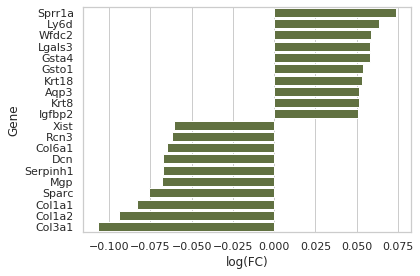

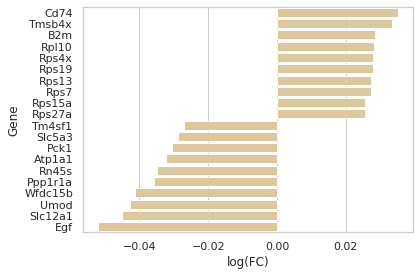

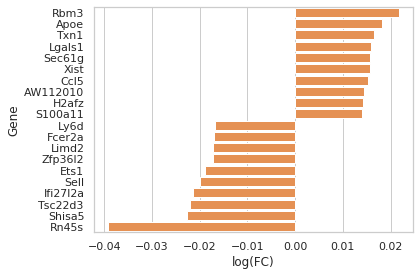

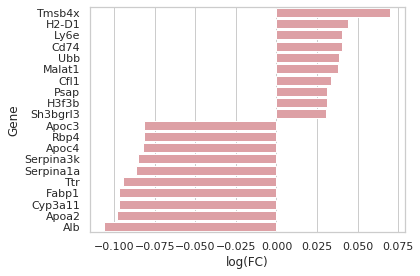

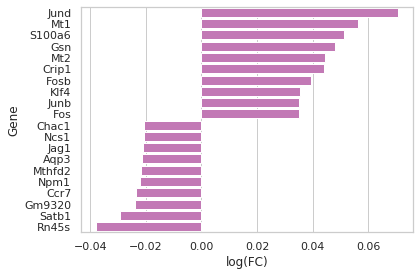

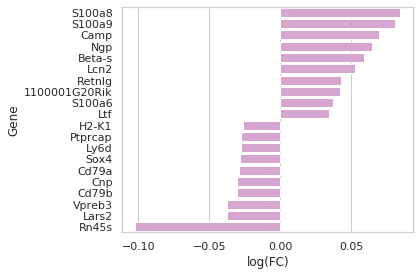

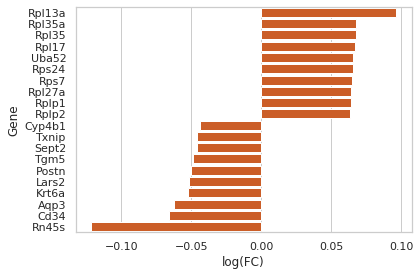

In [48]:
df_comparison = 0
    
for t in ['Bladder','Kidney','Spleen','Liver','Mammary_Gland','Marrow','Skin']:#tissue_dge_age_coef.columns:
    
    tiss_fdr = tissue_dge_bh_p[tissue_dge_bh_p[t]< fdr_threshold]
    tiss_age_coef = tissue_dge_age_coef.loc[tiss_fdr.index.values]
    tiss_age_coef = tiss_age_coef[np.absolute(tiss_age_coef[t])>age_coef_threshold][t]
    tiss_age_coef
    
    df = pd.DataFrame(tiss_age_coef.sort_values(ascending=False))
    df = df.reset_index()
    df.columns = ['gene','tissue']
    
    plt.figure()
    g = sns.barplot(data=pd.concat([df.head(10),df.tail(10)],axis=0),
                y='gene',x='tissue',
                    color = tissue_color_dict[t])
    g.set(xlabel='log(FC)', ylabel='Gene')
    plt.tight_layout()
    plt.savefig(t+'_dge.pdf')

## Load TISSUE-CELL TYPE DE result

In [49]:
tissue_dge_age_coef = pd.read_csv('./DGE_result.tissue_cell.age_coef.csv', index_col=0)
tissue_dge_age_coef
tissue_dge_bh_p = pd.read_csv('./DGE_result.tissue_cell.bh_p.csv', index_col=0)
tissue_dge_bh_p

,Aorta.aortic endothelial cell,Aorta.fibroblast of cardiac tissue,Aorta.professional antigen presenting cell,BAT.B cell,BAT.T cell,BAT.endothelial cell,BAT.mesenchymal stem cell of adipose,BAT.myeloid cell,Bladder.bladder cell,Bladder.bladder urothelial cell,...,Tongue.Langerhans cell,Tongue.basal cell of epidermis,Tongue.keratinocyte,Trachea.T cell,Trachea.basal epithelial cell of tracheobronchial tree,Trachea.endothelial cell,Trachea.fibroblast,Trachea.granulocyte,Trachea.macrophage,Trachea.smooth muscle cell of trachea
Xkr4,NaN,0.306618,0.564055,NaN,NaN,NaN,NaN,0.115564,2.295825e-01,2.352092e-01,...,NaN,9.251839e-01,7.971151e-01,0.757271,6.162302e-01,NaN,8.087822e-02,NaN,NaN,NaN
Rp1,0.988385,0.654630,0.471133,NaN,0.653417,NaN,4.853963e-01,0.118226,5.475836e-01,4.616987e-01,...,NaN,8.272101e-02,3.505357e-01,NaN,2.877942e-02,0.695401,5.797053e-01,NaN,NaN,NaN
Sox17,0.035006,1.000000,0.564055,0.021062,NaN,0.111934,6.697650e-01,0.190456,4.034871e-01,3.307004e-01,...,NaN,9.854669e-01,4.136809e-03,NaN,3.751526e-05,0.041632,4.350242e-01,0.728725,2.280826e-01,0.228824
Mrpl15,0.234727,0.026149,0.782510,0.499609,0.795275,0.480626,1.324099e-01,0.661456,7.615559e-22,1.133458e-10,...,0.975852,1.851691e-06,9.779780e-08,0.000002,1.606579e-08,0.631551,4.202860e-07,0.013471,2.004946e-02,0.192114
Lypla1,0.000347,0.144706,0.164349,0.034841,0.306953,0.054479,2.704820e-07,0.000134,2.266963e-13,3.520422e-40,...,0.957112,1.183747e-70,9.113584e-37,0.007914,8.250113e-13,0.056935,2.959109e-08,0.010980,8.929951e-03,0.603864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LOC434960,NaN,NaN,0.529938,NaN,NaN,NaN,NaN,0.428858,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LOC380994,0.554589,0.112930,0.564055,NaN,NaN,NaN,NaN,0.898406,2.042884e-01,NaN,...,NaN,NaN,5.264220e-01,NaN,4.462497e-01,0.777611,5.161684e-01,NaN,NaN,NaN
LOC100041346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.748881,NaN,NaN,...,NaN,NaN,NaN,0.886781,NaN,NaN,NaN,NaN,NaN,NaN
Sly,NaN,0.284748,NaN,NaN,NaN,NaN,NaN,0.309197,NaN,NaN,...,NaN,2.916440e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
sum(tissue_dge_age_coef.index.values == tissue_dge_bh_p.index.values)

20115

In [10]:
age_coef_threshold = 0.005
fdr_threshold = 0.01

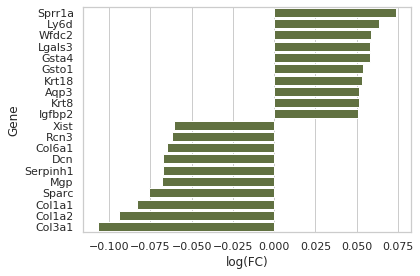

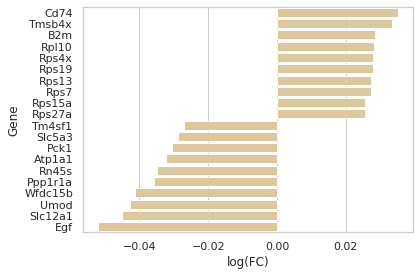

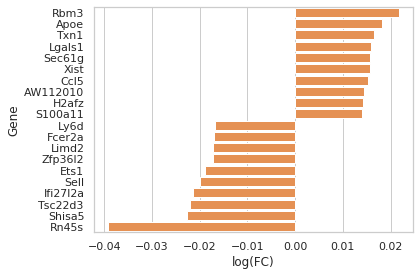

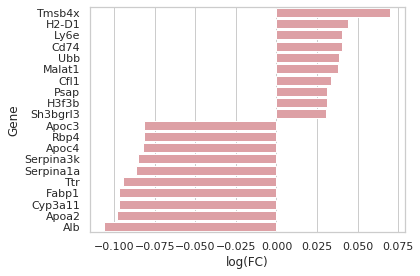

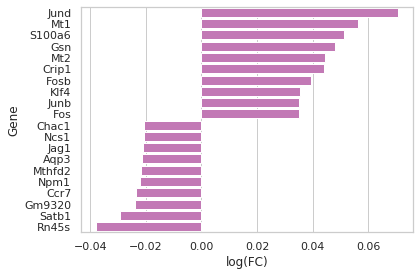

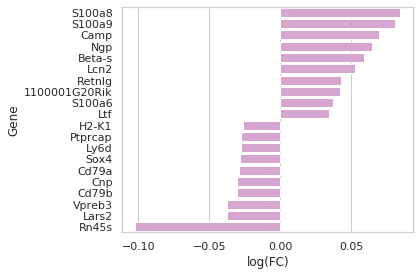

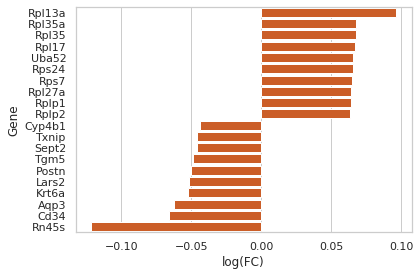

In [48]:
df_comparison = 0
    
for t in ['Bladder','Kidney','Spleen','Liver','Mammary_Gland','Marrow','Skin']:#tissue_dge_age_coef.columns:
    
    tiss_fdr = tissue_dge_bh_p[tissue_dge_bh_p[t]< fdr_threshold]
    tiss_age_coef = tissue_dge_age_coef.loc[tiss_fdr.index.values]
    tiss_age_coef = tiss_age_coef[np.absolute(tiss_age_coef[t])>age_coef_threshold][t]
    tiss_age_coef
    
    df = pd.DataFrame(tiss_age_coef.sort_values(ascending=False))
    df = df.reset_index()
    df.columns = ['gene','tissue']
    
    plt.figure()
    g = sns.barplot(data=pd.concat([df.head(10),df.tail(10)],axis=0),
                y='gene',x='tissue',
                    color = tissue_color_dict[t])
    g.set(xlabel='log(FC)', ylabel='Gene')
    plt.tight_layout()
    plt.savefig(t+'_dge.pdf')